In [1]:
from utility import EnglishTextProcessor
import numpy as np
from tqdm import tqdm
import json

In [3]:
import json
import os
import pickle

In [2]:
def load_json(filename):
    d = None
    with open(filename) as file:
        d = json.load(file)
    
    return d

In [4]:
etp = EnglishTextProcessor()
author = load_json('author_filtered_citations.json')

In [6]:
from aminer.recall.query_es import get_abstract_by_pids, get_references_by_pid

test_recs = {}
for id in author:
    test_recs[id] = get_references_by_pid(id)

In [7]:
relevant_ids = set(test_recs.keys())
for id in test_recs:
    relevant_ids = relevant_ids.union(test_recs[id])

In [8]:
relevant_id_keywords = {id:set() for id in relevant_ids}
for i in tqdm(range(411)):
    batch = load_json('../support/keyword_batches/{}.json'.format(i))
    for id in batch:
        if id in relevant_id_keywords:
            relevant_id_keywords[id] = batch[id]

100%|██████████| 411/411 [00:41<00:00,  9.86it/s]


In [10]:
overall = 0
threshold = 0.1
for id in test_recs:
    score = 0
    for rid in test_recs[id]:
        if len(set([k for k in relevant_id_keywords[rid] if relevant_id_keywords[rid][k] > threshold]).intersection(relevant_id_keywords[id])) > 0:
            score += 1
    
    overall += score / len(test_recs[id])

overall

83.07691843081028

In [11]:
candidate_sets = {id: {} for id in test_recs}

for i in tqdm(range(411)):
    batch = load_json('../support/keyword_batches/{}.json'.format(i))
    for id in test_recs:
        example_keywords = relevant_id_keywords[id]
        for bid in batch:
            intersection = set(batch[bid]).intersection(example_keywords)
            if len(intersection) > 0:
                keyword_importance = 0
                for k in intersection:
                    keyword_importance += batch[bid][k]

                candidate_sets[id][bid] = keyword_importance

 41%|████      | 167/411 [05:19<07:08,  1.76s/it]

KeyboardInterrupt: 

In [40]:
top_k = 100000
overall = 0
for id in sorted_candidate_sets:
    top_candidates = set(sorted_candidate_sets[id][:top_k])
    score = 0
    for cid in test_recs[id]:
        if cid in top_candidates:
            score += 1
    
    overall += score / len(test_recs[id])
overall

66.06550831787455

In [12]:
kw = load_json('../support/keyword_filtering_candidate_scores.json')

In [24]:
sorted_candidate_sets = {id: [] for id in candidate_sets}
for id in tqdm(candidate_sets):
    candidate_scores = kw[id]
    sorted_candidate_sets[id] = sorted(candidate_scores, reverse=True, key=lambda x: candidate_scores[x])


100%|██████████| 96/96 [01:03<00:00,  1.51it/s]


In [35]:
import matplotlib.pyplot as plt

ks = [100*(i+1) for i in range(50)]
ys = []

for k in ks:
    overall = 0
    for id in sorted_candidate_sets:
        top_candidates = set(sorted_candidate_sets[id][:k])
        score = 0
        for cid in test_recs[id]:
            if cid in top_candidates:
                score += 1

        overall += score / len(test_recs[id])

    ys += [overall]

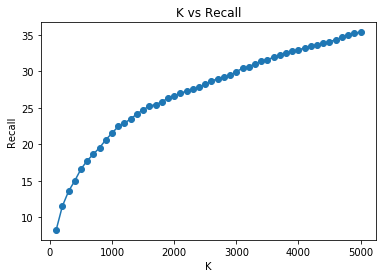

In [43]:
plt.title('K vs Recall')
plt.xlabel('K')
plt.ylabel('Recall')
plt.plot(ks, ys, marker='o')